In [35]:
import nibabel as nib
import numpy as np
import neuromaps
from os.path import join
from nilearn import maskers, masking, image, plotting
import scipy
from statsmodels.stats import multitest
import nilearn
from surfplot import Plot
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns




In [3]:
def read_gifti(gifti_fn):
    gii = nib.load(gifti_fn)
    data = np.vstack([da.data[np.newaxis, :]
                      for da in gii.darrays])
    return data

In [42]:
def plot_surf(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh, size=(200, 600), zoom=1.6, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=cm.seismic, cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()

def hemisphere_r2(r2_lh, r2_rh, taskname):

    # Set the font family to Helvetica or Arial for the plot
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']  # Replace 'Helvetica' with 'Arial' for Arial font

    # plot R2
    # Index ranging from 1 to 20
    sns.set_style("white")
    # add vertical line
    plt.axvline(x=10, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=50, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=100, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=200, color='gray', linestyle='--', linewidth=1)

    index = range(0, 200,10)
    
    # Plot the data points
    sns.lineplot(x=index, y=r2_lh, marker='o', linestyle='-', color="green", label="Left hemi.")
    sns.lineplot(x=index, y=r2_rh, marker='o', linestyle='-', color="#FFA318", label="Right hemi.")

    plt.xlabel('No. of basis functions', fontsize=16)
    plt.ylabel('Reconstruction accuracy', fontsize=16)
    plt.title(f'Variance explained as a function of additive basis functions: task-{taskname}')
    plt.legend(loc='lower right')
    plt.xticks([0, 10, 50, 100, 200])
    plt.xlim(0, 200)
    plt.ylim(0, 1)
    sns.despine()
    plt.show()



In [5]:
def freq_filter_mat(basis_matrix, data_matrix, n_components):

    # linear combination left hemisphere
    Plh = basis_matrix[:n_components, :]
    F = Plh.T@Plh
    print(f"* frequency filter matrix {F.shape}\n* contrast map shape {data_matrix.shape}")
    reconstruct = data_matrix @ F
    return reconstruct


def load_mask(refimg_fname, mask_fname, smoothing):
    imgfname = refimg_fname# '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
    ref_img = image.load_img(imgfname)

    mask = image.load_img(mask_fname) #'/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
    mask_img = masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

    nifti_masker = maskers.NiftiMasker(mask_img= mask_img,
                                            smoothing_fwhm=smoothing,
                                target_affine = ref_img.affine, target_shape = ref_img.shape, 
                        memory="nilearn_cache", memory_level=1)
    return nifti_masker
def mask_singletrial(npyarray, refimg_fname, nifti_masker):
    ref_img = image.load_img(refimg_fname)
    x,y,z=ref_img.shape
    masked_append = []
    for index in range(npyarray.shape[0]):
        masked_append.append(
            nifti_masker.fit_transform(
        image.new_img_like(ref_img, npyarray[index].reshape(x,y,z)))
        )
    masked_arr = np.vstack(masked_append)
    return masked_arr

def fdr_correct(masked_array, tvalues, qvalues, threshold, nifti_masker):
    result_mapp = np.zeros(masked_array.shape[1])
    result_mapp[qvalues < threshold] = tvalues[qvalues < threshold]
    con_tmapp = nifti_masker.inverse_transform(result_mapp)
    return con_tmapp


In [6]:
main_dir = '/Users/h/Documents/projects_local/cue_expectancy'

# extract gii from cifti (bash)
INPUT="/tmp/spectral_bases_200.dscalar.nii"
OUTPUT="/tmp/basis_L.func.gii"
/Applications/workbench/bin_macosx64/wb_command -cifti-separate ${INPUT} COLUMN -metric CORTEX_LEFT ${OUTPUT}

INPUT="/tmp/spectral_bases_200.dscalar.nii"
OUTPUT="/tmp/basis_R.func.gii"
/Applications/workbench/bin_macosx64/wb_command -cifti-separate ${INPUT} COLUMN -metric CORTEX_RIGHT ${OUTPUT}


/Applications/workbench/bin_macosx64/wb_command -cifti-separate /Users/h/Documents/projects_local/sandbox/fmriprep_bold/surface/sub-0061_ses-01_task-social_acq-mb8_run-1_space-fsLR_den-91k_bold.dtseries.nii COLUMN -metric CORTEX_LEFT test_left.func.gii

## pain

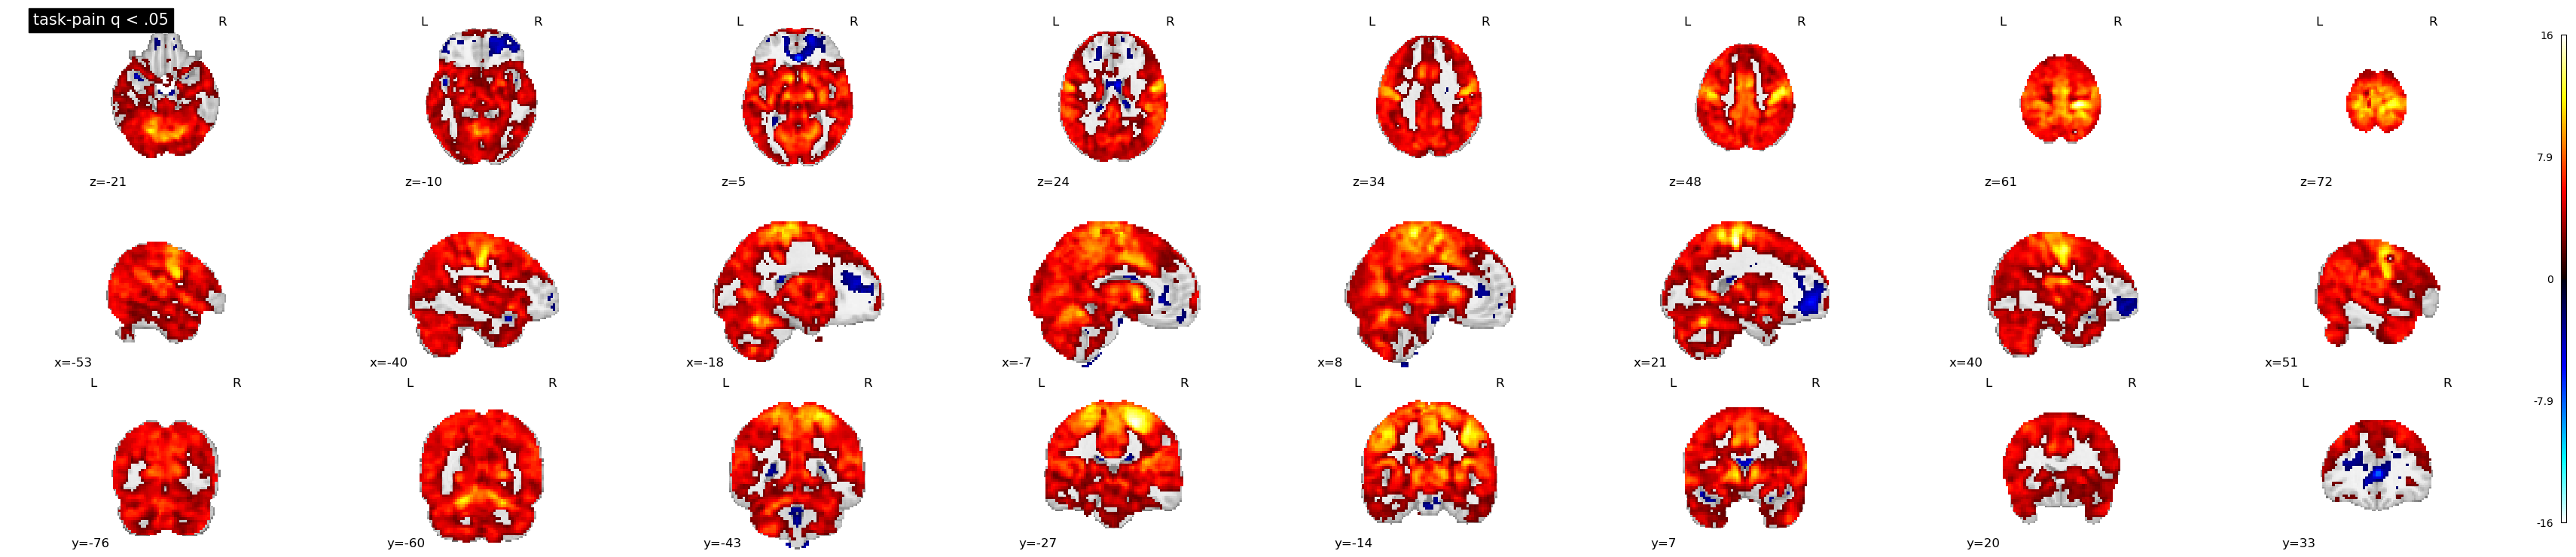

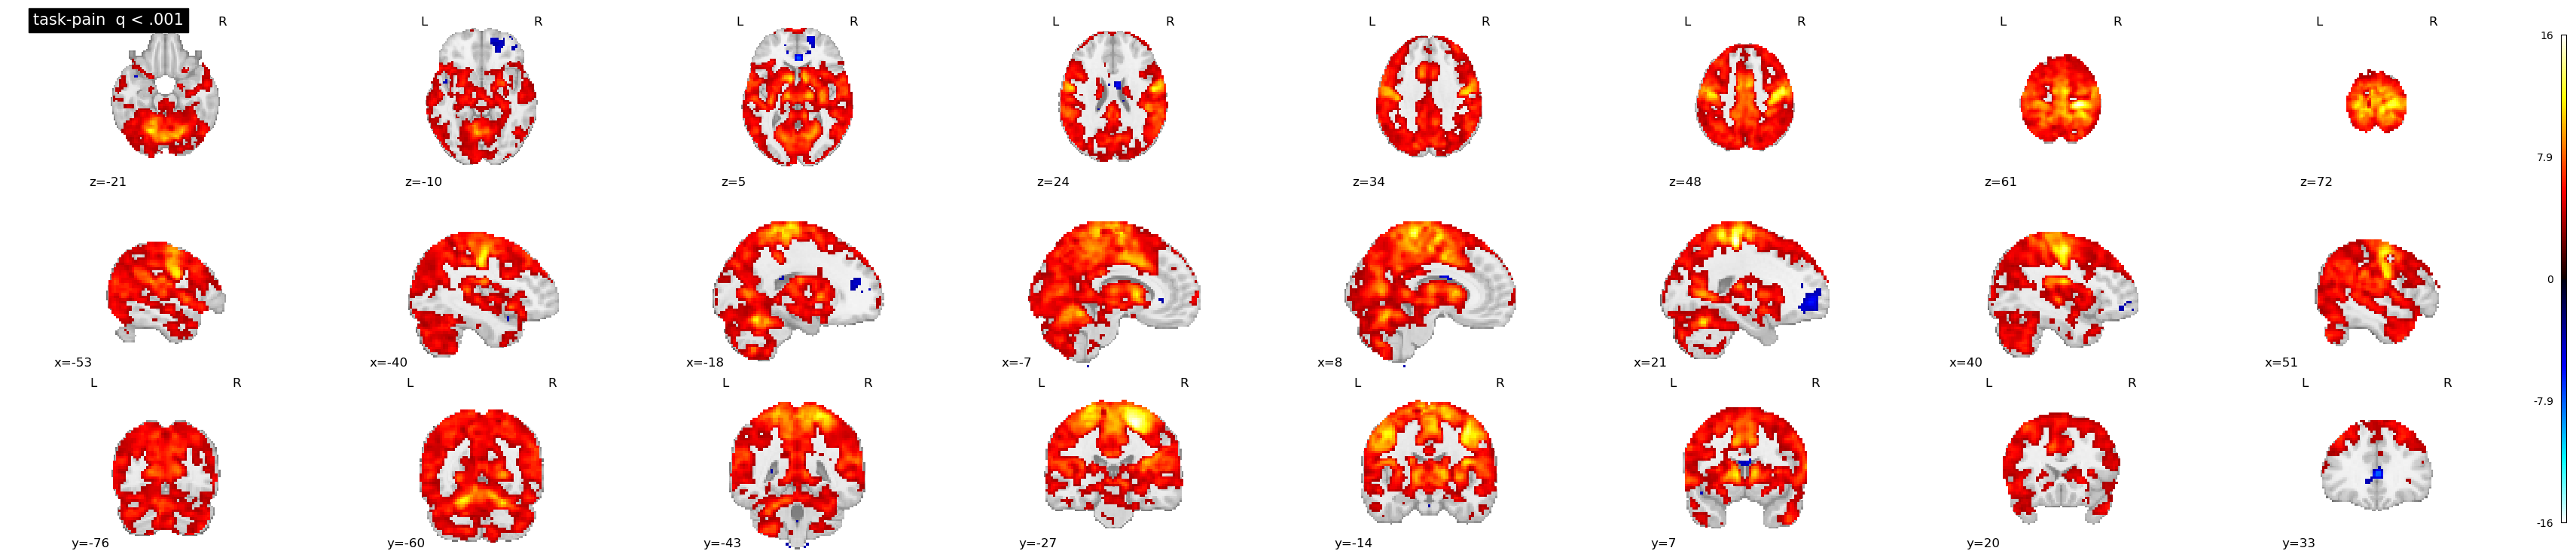

In [13]:
# stack group surface maps
refimg_fname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
mask_fname = '/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii'
# masker: 
nifti_masker = load_mask(refimg_fname=refimg_fname,
                         mask_fname=mask_fname,
                         smoothing=6)

# transform vol to surf
main_dir = '/Volumes/spacetop_projects_cue'
npy_dir = join(main_dir,'analysis/fmri/nilearn/deriv05_singletrialnpy')
suballHv = np.load(join(npy_dir,'sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-high.npy'))
suballLv = np.load(join(npy_dir,'sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-low.npy'))

fmri_masked_stimhighp = mask_singletrial(npyarray=suballHv, refimg_fname=refimg_fname, nifti_masker=nifti_masker)
fmri_masked_stimlowp = mask_singletrial(npyarray=suballLv, refimg_fname=refimg_fname, nifti_masker=nifti_masker)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighp, fmri_masked_stimlowp, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

con_tmapp = fdr_correct(masked_array=fmri_masked_stimhighp,
                        tvalues=tvalues, qvalues=qvalues, threshold=0.05, nifti_masker=nifti_masker)
con_tmap_001p = fdr_correct(masked_array=fmri_masked_stimhighp,
                        tvalues=tvalues, qvalues=qvalues, threshold=0.001, nifti_masker=nifti_masker)

con_tmap_unthres = nifti_masker.inverse_transform(tvalues)
con_tmap_unthres.to_filename('/tmp/task-pain_tmap-stim_thres-unc.nii.gz')
plotting.plot_stat_map(con_tmapp,  display_mode='mosaic', title='task-pain q < .05', cut_coords=8)
plotting.plot_stat_map(con_tmap_001p,  display_mode='mosaic', title='task-pain  q < .001', cut_coords=8)

stimHgtL_P = neuromaps.transforms.mni152_to_fslr('/tmp/task-pain_tmap-stim_thres-unc.nii.gz', fslr_density='32k', method='linear')

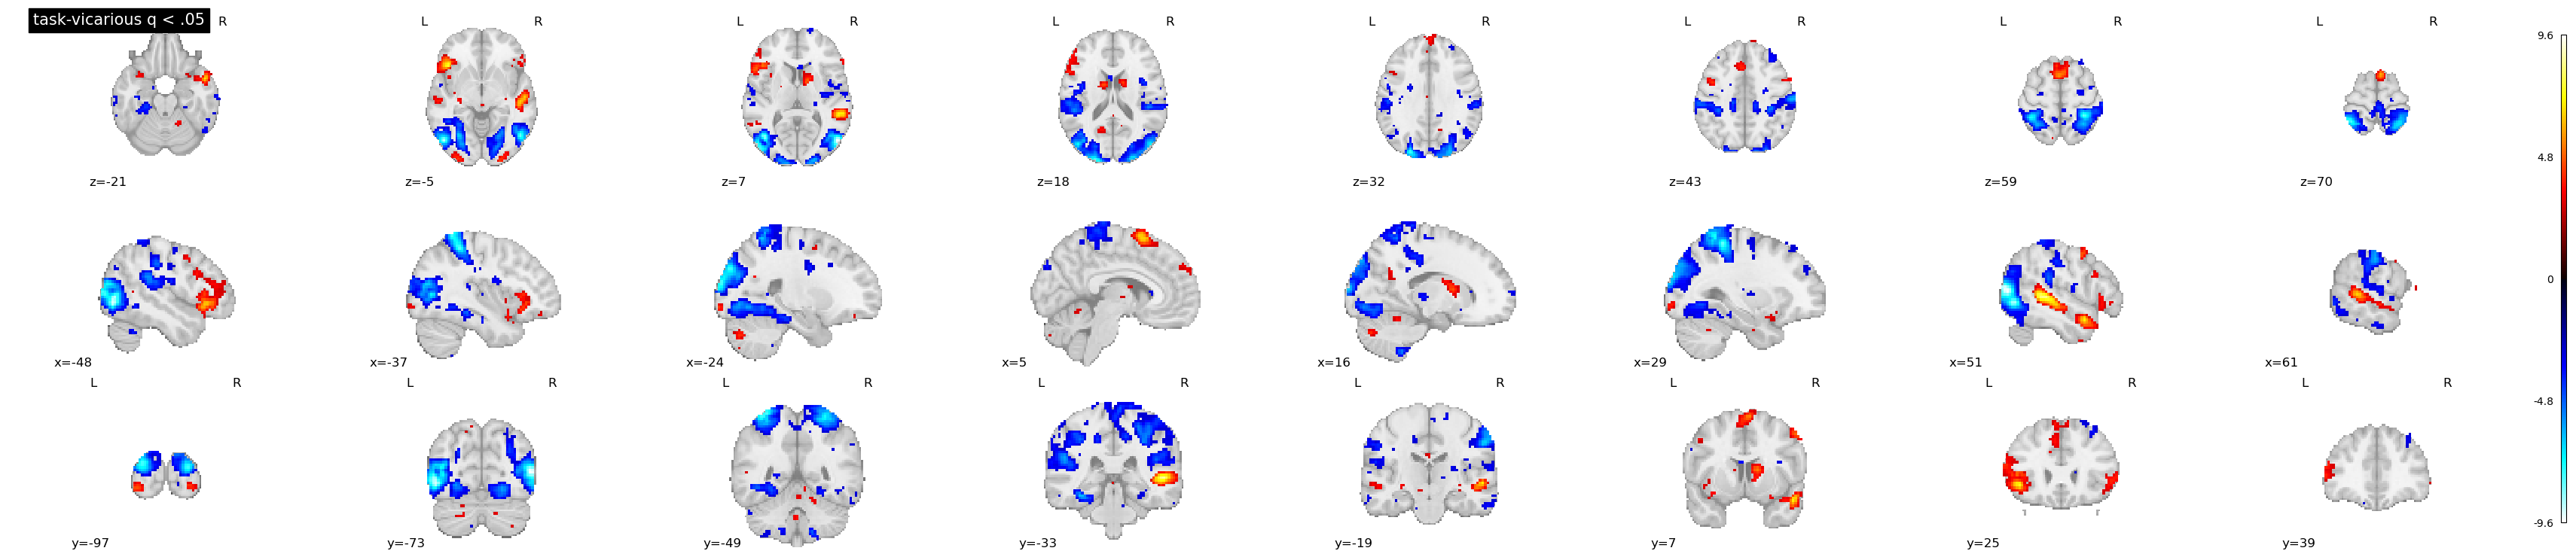

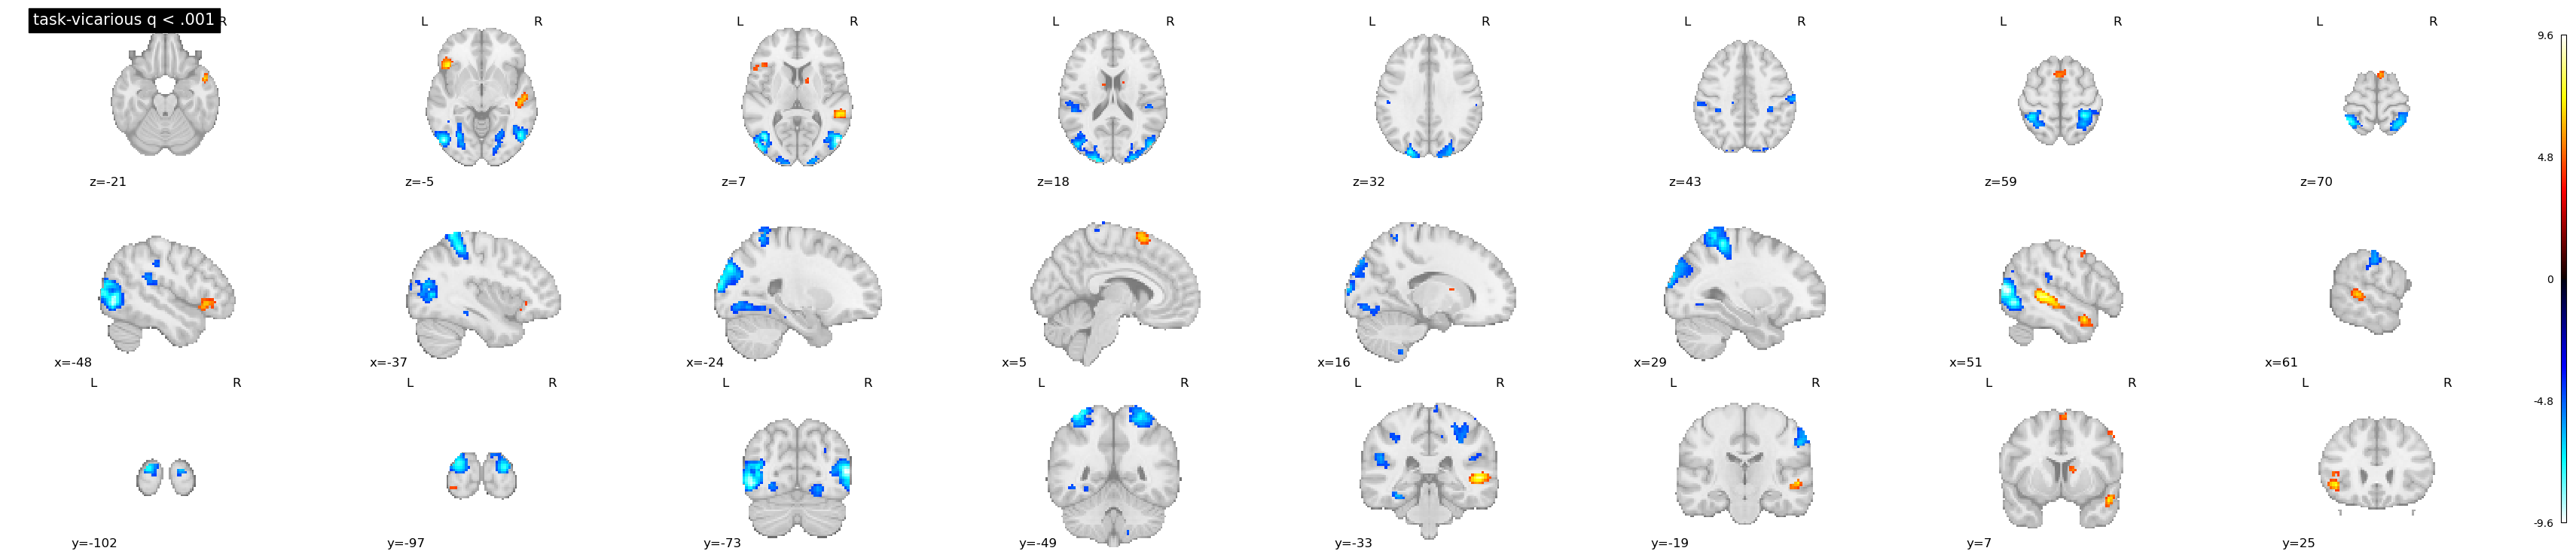

In [17]:
# stack group surface maps
refimg_fname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
mask_fname = '/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii'
# masker: 
nifti_masker = load_mask(refimg_fname=refimg_fname,
                         mask_fname=mask_fname,
                         smoothing=6)

# transform vol to surf
main_dir = '/Volumes/spacetop_projects_cue'
npy_dir = join(main_dir,'analysis/fmri/nilearn/deriv05_singletrialnpy')
suballHv = np.load(join(npy_dir,'sub-avg_ses-avg_run-avg_task-vicarious_event-stimulus_stimintensity-high.npy'))
suballLv = np.load(join(npy_dir,'sub-avg_ses-avg_run-avg_task-vicarious_event-stimulus_stimintensity-low.npy'))

fmri_masked_stimhighp = mask_singletrial(npyarray=suballHv, refimg_fname=refimg_fname, nifti_masker=nifti_masker)
fmri_masked_stimlowp = mask_singletrial(npyarray=suballLv, refimg_fname=refimg_fname, nifti_masker=nifti_masker)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighp, fmri_masked_stimlowp, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

con_tmapp = fdr_correct(masked_array=fmri_masked_stimhighp,
                        tvalues=tvalues, qvalues=qvalues, threshold=0.05, nifti_masker=nifti_masker)
con_tmap_001p = fdr_correct(masked_array=fmri_masked_stimhighp,
                        tvalues=tvalues, qvalues=qvalues, threshold=0.001, nifti_masker=nifti_masker)

con_tmap_unthres = nifti_masker.inverse_transform(tvalues)
con_tmap_unthres.to_filename('/tmp/task-vicarious_tmap-stim_thres-unc.nii.gz')
plotting.plot_stat_map(con_tmapp,  display_mode = 'mosaic', title = 'task-vicarious q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmap_001p,  display_mode = 'mosaic', title = 'task-vicarious q < .001', cut_coords = 8)

stimHgtL_V = neuromaps.transforms.mni152_to_fslr('/tmp/task-vicarious_tmap-stim_thres-unc.nii.gz', fslr_density='32k', method='linear')

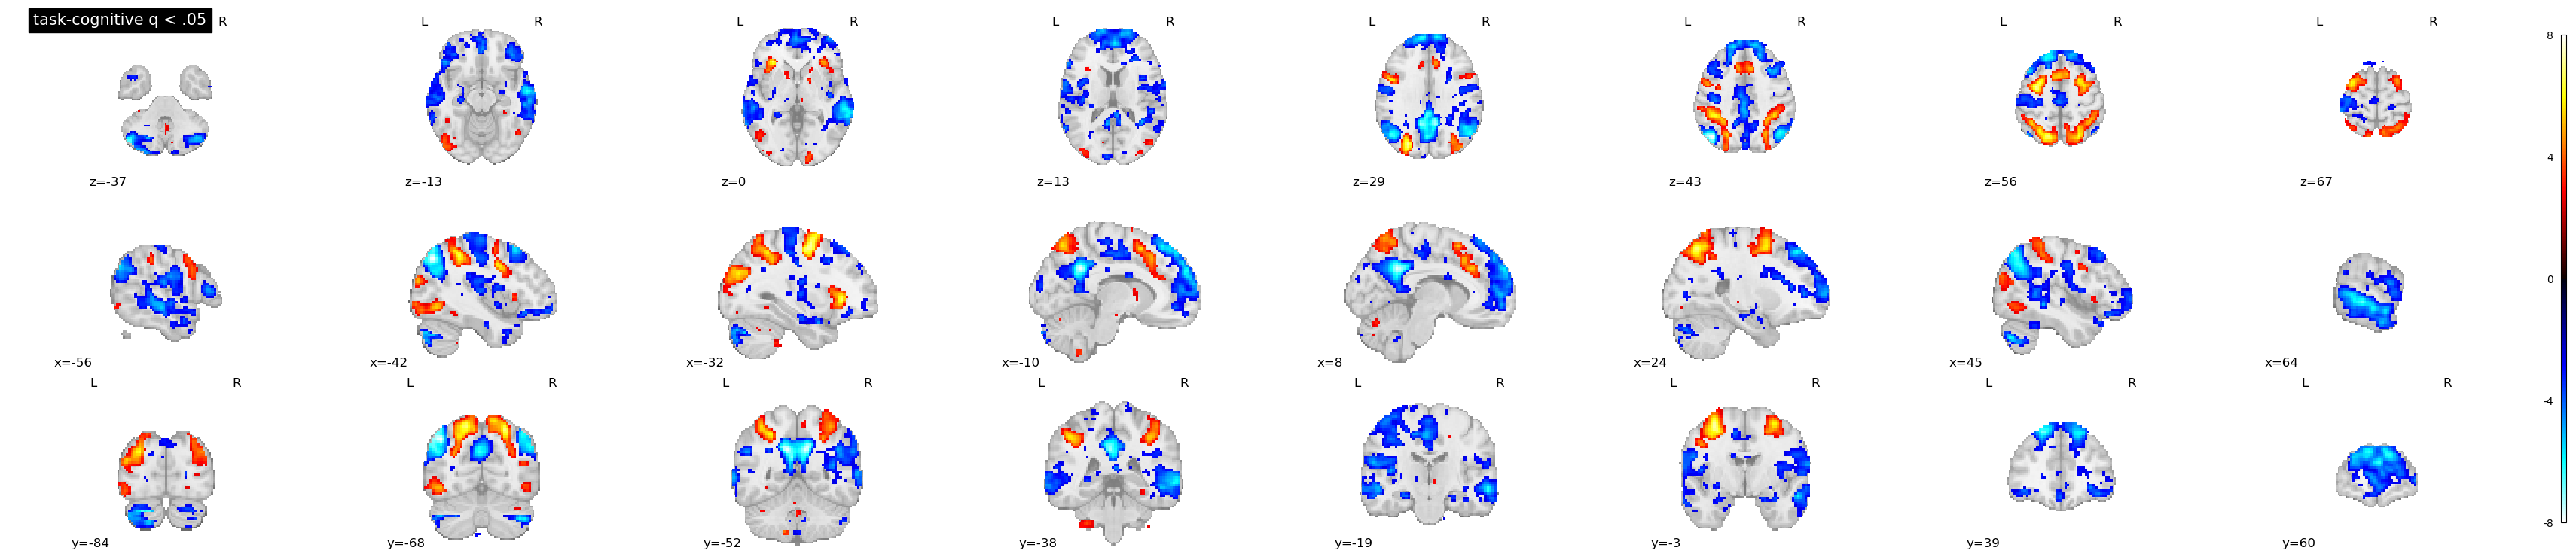

In [18]:
# stack group surface maps
refimg_fname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
mask_fname = '/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii'
# masker: 
nifti_masker = load_mask(refimg_fname=refimg_fname,
                         mask_fname=mask_fname,
                         smoothing=6)

# transform vol to surf
main_dir = '/Volumes/spacetop_projects_cue'
npy_dir = join(main_dir,'analysis/fmri/nilearn/deriv05_singletrialnpy')
suballHv = np.load(join(npy_dir,'sub-avg_ses-avg_run-avg_task-cognitive_event-stimulus_stimintensity-high.npy'))
suballLv = np.load(join(npy_dir,'sub-avg_ses-avg_run-avg_task-cognitive_event-stimulus_stimintensity-low.npy'))

fmri_masked_stimhighp = mask_singletrial(npyarray=suballHv, refimg_fname=refimg_fname, nifti_masker=nifti_masker)
fmri_masked_stimlowp = mask_singletrial(npyarray=suballLv, refimg_fname=refimg_fname, nifti_masker=nifti_masker)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighp, fmri_masked_stimlowp, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

con_tmapp = fdr_correct(masked_array=fmri_masked_stimhighp,
                        tvalues=tvalues, qvalues=qvalues, threshold=0.05, nifti_masker=nifti_masker)
con_tmap_001p = fdr_correct(masked_array=fmri_masked_stimhighp,
                        tvalues=tvalues, qvalues=qvalues, threshold=0.001, nifti_masker=nifti_masker)

con_tmap_unthres = nifti_masker.inverse_transform(tvalues)
con_tmap_unthres.to_filename('/tmp/task-cognitive_tmap-stim_thres-unc.nii.gz')
plotting.plot_stat_map(con_tmapp,  display_mode = 'mosaic', title = 'task-cognitive q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmap_001p,  display_mode = 'mosaic', title = 'task-cognitive  q < .001', cut_coords = 8)

stimHgtL_C = neuromaps.transforms.mni152_to_fslr('/tmp/task-cognitive_tmap-stim_thres-unc.nii.gz', fslr_density='32k', method='linear')

In [19]:
nib.save(stimHgtL_P[0], '/tmp/stimHgtL_P_lh.func.gii')
nib.save(stimHgtL_P[1], '/tmp/stimHgtL_P_rh.func.gii')
nib.save(stimHgtL_V[0], '/tmp/stimHgtL_V_lh.func.gii')
nib.save(stimHgtL_V[1], '/tmp/stimHgtL_V_rh.func.gii')
nib.save(stimHgtL_C[0], '/tmp/stimHgtL_C_lh.func.gii')
nib.save(stimHgtL_C[1], '/tmp/stimHgtL_C_rh.func.gii')

In [20]:
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data
stimV_lh = stimHgtL_V[0].darrays[0].data
stimV_rh = stimHgtL_V[1].darrays[0].data
stimC_lh = stimHgtL_C[0].darrays[0].data
stimC_rh = stimHgtL_C[1].darrays[0].data

# basis function

In [21]:
# load basis functions
basis = nib.load('/tmp/basis_L.func.gii')
basis_lh = read_gifti('/tmp/basis_L.func.gii')
basis_rh = read_gifti('/tmp/basis_R.func.gii')

In [22]:
pvc_stack_lh = np.vstack([stimP_lh,
                            stimV_lh,
                            stimC_lh])
pvc_stack_rh = np.vstack([stimP_rh,
                            stimV_rh,
                            stimC_rh])

# get weights of basis functions per contrast for each hemiphere
basis_wlh = np.matmul(basis_lh, pvc_stack_lh.T)
basis_wrh = np.matmul(basis_rh, pvc_stack_rh.T)

In [23]:
pvc_stack_rh.shape


(3, 32492)

# plot contrast and basis function just to check

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/798462744.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/798462744.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


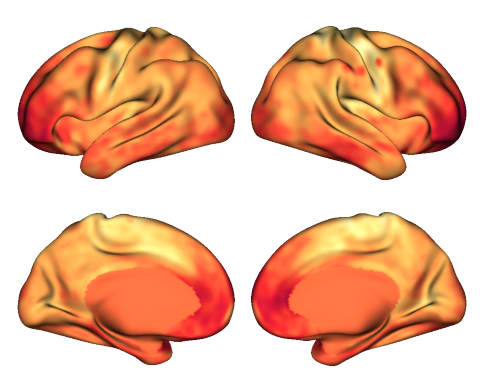

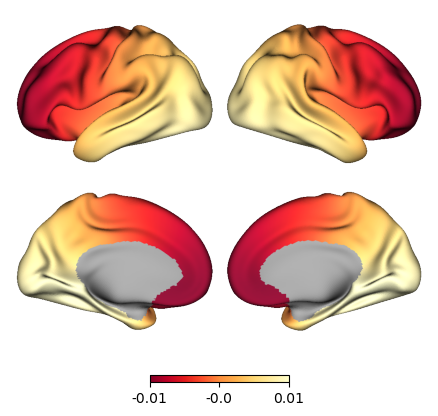

In [29]:
surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
lh, rh = surfaces['inflated']

p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer({'left': stimP_lh, 
             'right': stimP_rh}, 
             cmap='YlOrRd_r', cbar=False)
fig = p.build()
fig.show()

b = Plot(surf_lh=lh, surf_rh=rh)
b.add_layer({'left': basis_lh[1], 'right': basis_rh[1]}, cmap='YlOrRd_r', cbar=True)
fig = b.build()
fig.show()

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


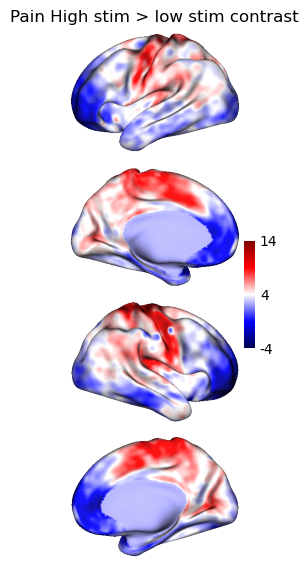

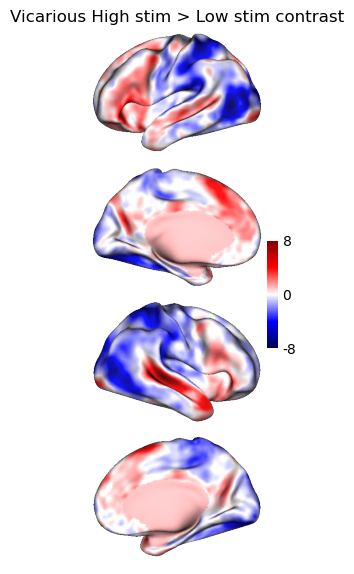

In [43]:
# plot
surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
plot_surf(surfaces, 
          surf_lh=stimP_lh, 
          surf_rh= stimP_rh, 
          title=f'Pain High stim > low stim contrast')
plot_surf(surfaces, 
          surf_lh=stimV_lh, 
          surf_rh= stimV_rh, 
          title=f'Vicarious High stim > Low stim contrast')
plot_surf(surfaces, 
          surf_lh=stimC_lh, 
          surf_rh= stimC_rh, 
          title=f'Cognitive High stim > low cue contrast')

# get first 10 basis functions

In [44]:
n_basis = 10
r2_painlh = sum(basis_wlh[:n_basis,1]**2) / sum(stimP_lh ** 2)#sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_lh[:, np.newaxis].T**2))
r2_painrh = sum(basis_wrh[:n_basis,1]**2) / sum(stimP_rh ** 2) #(sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_rh[:, np.newaxis].T**2))

print(f"R2, first {n_basis} components, lh: {r2_painlh}")
print(f"R2, first {n_basis} components, rh: {r2_painrh}")

R2, first 10 components, lh: 0.057984294733180716
R2, first 10 components, rh: 0.06912939893355066


In [45]:
# linear combination
cumsum_pain_L = basis_wlh[:10,1].reshape(10,1) @ stimP_lh.T.reshape(1,32492)
cumsum_pain_R = basis_wrh[:10,1].reshape(10,1) @ stimP_rh.T.reshape(1,32492)
cumul_pain_lh = cumsum_pain_L.sum(axis=0)
cumul_pain_rh = cumsum_pain_R.sum(axis=0)

In [46]:
cumsum_pain_L.shape

(10, 32492)

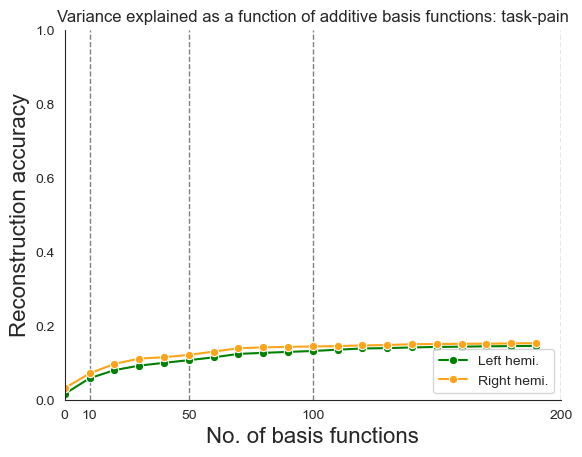

In [47]:
# get R2 per BF componetns
r2_Plh_append = []
r2_Prh_append = []
for n_basis in np.arange(1,200,10): 
    r2_Plh = sum(basis_wlh[:n_basis,1]**2) / sum(stimP_lh ** 2)#sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_lh[:, np.newaxis].T**2))
    r2_Prh = sum(basis_wrh[:n_basis,1]**2) / sum(stimP_rh ** 2) #(sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_rh[:, np.newaxis].T**2))
    r2_Plh_append.append(r2_Plh)
    r2_Prh_append.append(r2_Prh)

hemisphere_r2(r2_lh=r2_Plh_append,r2_rh=r2_Prh_append,taskname='pain' )

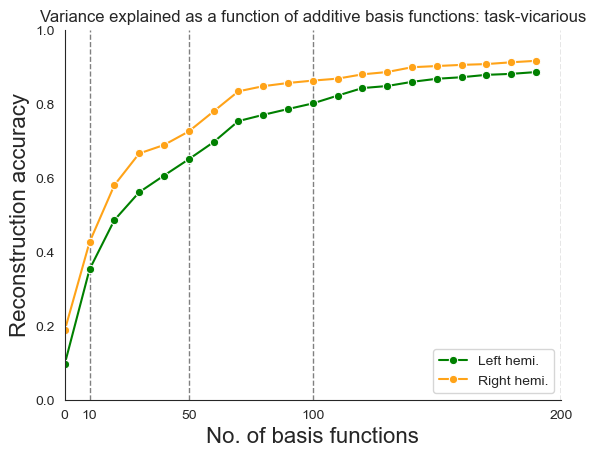

In [48]:
# get R2 per BF componetns
r2_viclh_append = []
r2_vicrh_append = []
for n_basis in np.arange(1,200,10): 
    r2_viclh = sum(basis_wlh[:n_basis,1]**2) / sum(stimV_lh ** 2)#sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_lh[:, np.newaxis].T**2))
    r2_vicrh = sum(basis_wrh[:n_basis,1]**2) / sum(stimV_rh ** 2) #(sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_rh[:, np.newaxis].T**2))
    r2_viclh_append.append(r2_viclh)
    r2_vicrh_append.append(r2_vicrh)

hemisphere_r2(r2_lh=r2_viclh_append,r2_rh=r2_vicrh_append,taskname='vicarious' )

In [49]:
# get R2 per BF componetns
r2_Clh_append = []
r2_Crh_append = []
for n_basis in np.arange(1,200,10): 
    r2_Clh = sum(basis_wlh[:n_basis,1]**2) / sum(stimC_lh ** 2)#sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_lh[:, np.newaxis].T**2))
    r2_Crh = sum(basis_wrh[:n_basis,1]**2) / sum(stimC_rh ** 2) #(sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_rh[:, np.newaxis].T**2))
    r2_Clh_append.append(r2_Clh)
    r2_Crh_append.append(r2_Crh)

hemisphere_r2(r2_lh=r2_Clh_append,r2_rh=r2_Crh_append,taskname='cognitive' )

R2, first 10 components, lh: 0.3525771837680137
R2, first 10 components, rh: 0.4141036347912184


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/4082398320.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


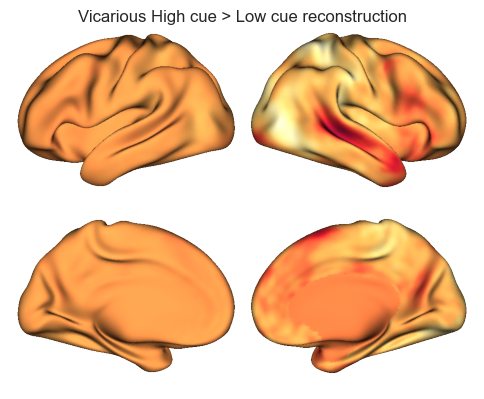

In [50]:
n_basis = 10
r2_viclh = sum(basis_wlh[:n_basis,1]**2) / sum(stimV_lh ** 2)#sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_lh[:, np.newaxis].T**2))
r2_vicrh = sum(basis_wrh[:n_basis,1]**2) / sum(stimV_rh ** 2) #(sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_rh[:, np.newaxis].T**2))

print(f"R2, first {n_basis} components, lh: {r2_viclh}")
print(f"R2, first {n_basis} components, rh: {r2_vicrh}")

cumsum_vic_lh = basis_wlh[:10,1].reshape(10,1) * stimV_lh.T.reshape(1,32492)
cumsum_vic_rh = basis_wrh[:10,1].reshape(10,1) * stimV_rh.T.reshape(1,32492)
cumsum_vic_lh = cumsum_vic_lh.sum(axis=0)
cumsum_vic_rh = cumsum_vic_rh.sum(axis=0)

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
lh, rh = surfaces['inflated']

p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer({'left': cumsum_vic_lh, 'right': cumsum_vic_rh}, cmap='YlOrRd_r', cbar=False)
# fig = p.build()
# fig.show()

kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
           decimals=0, pad=0)
fig = p.build(cbar_kws=kws)
fig.axes[0].set_title('Vicarious High cue > Low cue reconstruction', pad=-3)
fig.show()


R2, first 10 components, lh: 0.24424094463563606
R2, first 10 components, rh: 0.39328844992601036


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/2710223686.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


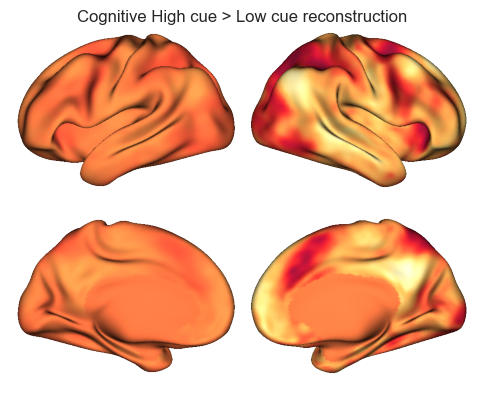

In [51]:
n_basis = 10
r2_coglh = sum(basis_wlh[:n_basis,1]**2) / sum(stimC_lh ** 2)#sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_lh[:, np.newaxis].T**2))
r2_cogrh = sum(basis_wrh[:n_basis,1]**2) / sum(stimC_rh ** 2) #(sum((basis_w[:10,1]**2).reshape((10, 1))) / sum((stimP_rh[:, np.newaxis].T**2))

print(f"R2, first {n_basis} components, lh: {r2_coglh}")
print(f"R2, first {n_basis} components, rh: {r2_cogrh}")

cumsum_cog_lh = basis_wlh[:10,1].reshape(10,1) * stimC_lh.T.reshape(1,32492)
cumsum_cog_rh = basis_wrh[:10,1].reshape(10,1) * stimC_rh.T.reshape(1,32492)
cumsum_cog_lh = cumsum_cog_lh.sum(axis=0)
cumsum_cog_rh = cumsum_cog_rh.sum(axis=0)

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
lh, rh = surfaces['inflated']

p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer({'left': cumsum_cog_lh, 'right': cumsum_cog_rh}, cmap='YlOrRd_r', cbar=False)
# fig = p.build()

kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
           decimals=0, pad=0)
fig = p.build(cbar_kws=kws)
fig.axes[0].set_title('Cognitive High cue > Low cue reconstruction', pad=-3)
fig.show()


## Bogdan method

In [54]:
n_components = 100
# linear combination left hemisphere
Plh = basis_lh[:n_components, :]
F = Plh.T@Plh
print(f"* LH frequency filter matrix {F.shape}\n* contrast map shape {stimP_lh.shape}")
n_bf_stimHgtL_P_lh = stimP_lh @ F
# linear combination right hemisphere
Prh = basis_rh[:n_components, :]
F = Plh.T@Prh
print(f"* RH frequency filter matrix {F.shape}\n* contrast map shape {stimP_rh.shape}")
n_bf_stimHgtL_P_rh = stimP_rh @ F


surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
lh, rh = surfaces['inflated']

p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer({'left': n_bf_stimHgtL_P_lh, 
             'right': n_bf_stimHgtL_P_rh}, #stimP_rh}, 
             cmap=cm.seismic, cbar=True)

kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
           decimals=0, pad=0)
fig = p.build(cbar_kws=kws)
fig.axes[0].set_title(f'Pain High stim > low stim reconstruction\n{n_components} no. of basis functions', pad=-3)

fig.show()

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1954682610.py:4: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* LH frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* RH frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1954682610.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


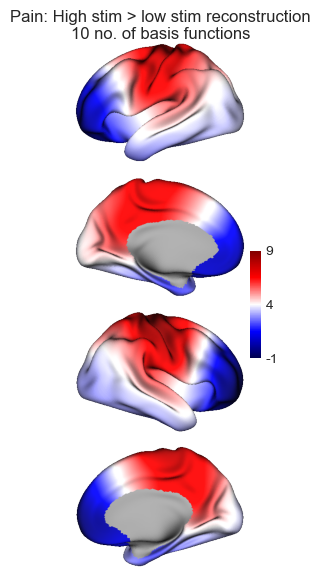

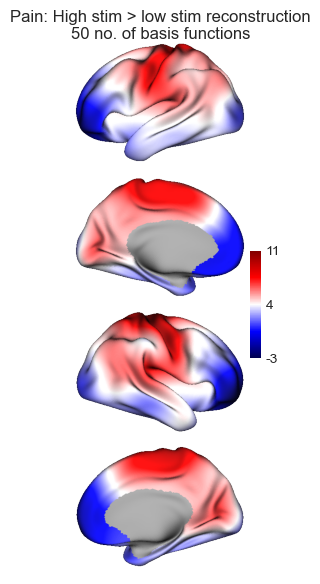

In [58]:
for n_components in [10, 50, 100, 200]:
    taskname = 'pain'
    n_bf_stimHgtL_V_lh = freq_filter_mat(basis_matrix=basis_lh, data_matrix=stimP_lh, n_components=n_components)
    n_bf_stimHgtL_V_rh = freq_filter_mat(basis_matrix=basis_rh, data_matrix=stimP_rh, n_components=n_components)

    surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
    plot_surf(surfaces, 
            surf_lh=n_bf_stimHgtL_V_lh, 
            surf_rh= n_bf_stimHgtL_V_rh, 
            title=f'{taskname.title()}: High stim > low stim reconstruction\n{n_components} no. of basis functions')

## vicarious

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


Context leak detected, msgtracer returned -1
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


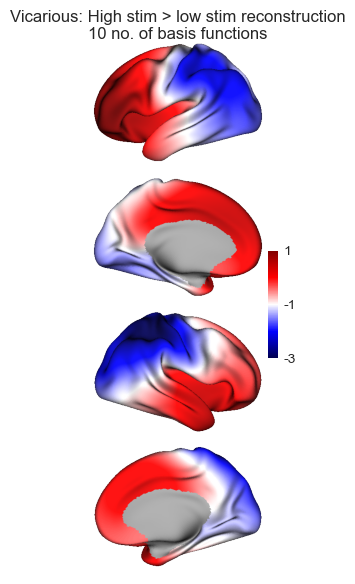

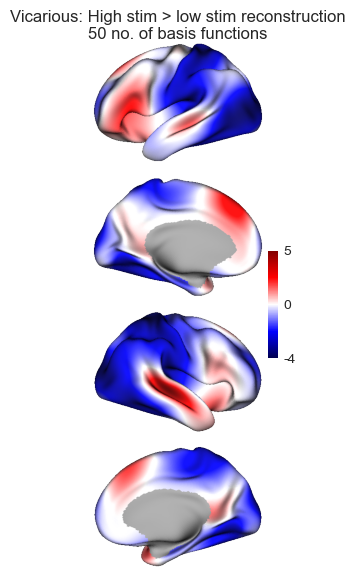

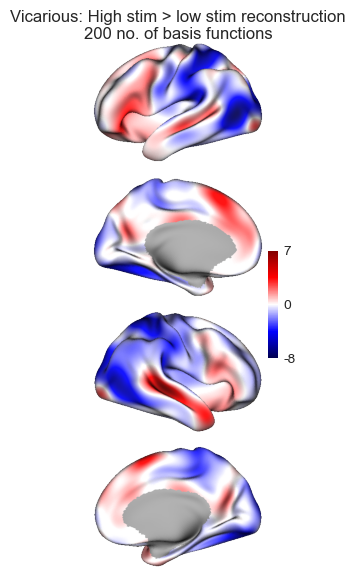

In [59]:
for n_components in [10, 50, 100, 200]:
    taskname = 'vicarious'
    n_bf_stimHgtL_V_lh = freq_filter_mat(basis_matrix=basis_lh, data_matrix=stimV_lh, n_components=n_components)
    n_bf_stimHgtL_V_rh = freq_filter_mat(basis_matrix=basis_rh, data_matrix=stimV_rh, n_components=n_components)

    surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
    plot_surf(surfaces, 
            surf_lh=n_bf_stimHgtL_V_lh, 
            surf_rh= n_bf_stimHgtL_V_rh, 
            title=f'{taskname.title()}: High stim > low stim reconstruction\n{n_components} no. of basis functions')

## cognitive

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_92131/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


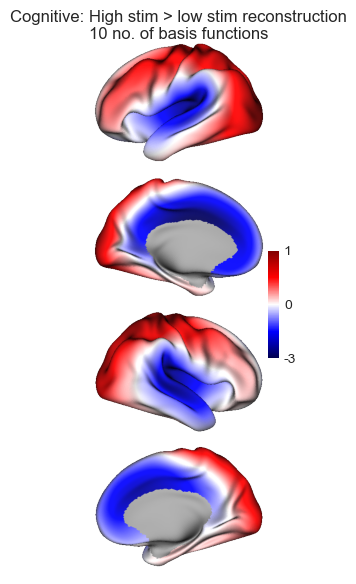

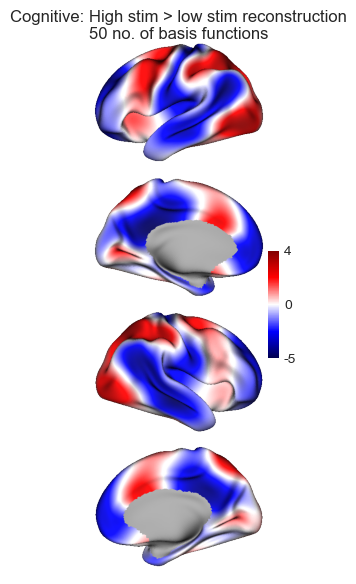

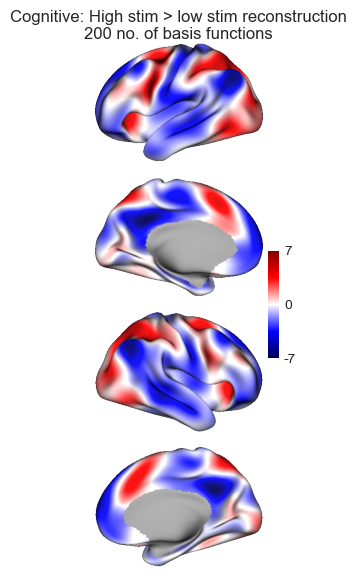

In [61]:
for n_components in [10, 50, 100, 200]:
    taskname = 'cognitive'
    n_bf_stimHgtL_C_lh = freq_filter_mat(basis_matrix=basis_lh, data_matrix=stimC_lh, n_components=n_components)
    n_bf_stimHgtL_C_rh = freq_filter_mat(basis_matrix=basis_rh, data_matrix=stimC_rh, n_components=n_components)

    surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
    plot_surf(surfaces, 
            surf_lh=n_bf_stimHgtL_C_lh, 
            surf_rh= n_bf_stimHgtL_C_rh, 
            title=f'{taskname.title()}: High stim > low stim reconstruction\n{n_components} no. of basis functions')